# Oxford Flowers 102 - Data Pipeline

This notebook downloads the Oxford Flowers 102 dataset, creates custom stratified 50/25/25 splits, and provides exploratory visualization.

## Setup Instructions (Google Colab)

1. Go to **Runtime > Change runtime type**
2. Select **GPU** as the hardware accelerator
3. Click **Save**

This ensures faster data loading and is required for later model training notebooks.

In [1]:
# Imports
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import os
import pickle

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Mount Google Drive for data and model persistence
from google.colab import drive
drive.mount('/content/drive')

# Set base path for project files
BASE_PATH = '/content/drive/MyDrive/CNN'
DATA_DIR = os.path.join(BASE_PATH, 'data')
OUTPUTS_DIR = os.path.join(BASE_PATH, 'outputs')

# Create directories if needed
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(OUTPUTS_DIR, exist_ok=True)

print(f"Project path: {BASE_PATH}")
print(f"Data directory: {DATA_DIR}")

Mounted at /content/drive
Project path: /content/drive/MyDrive/CNN
Data directory: /content/drive/MyDrive/CNN/data


In [3]:
# Configuration
IMG_SIZE = (224, 224)  # Standard size for VGG19, ResNet
BATCH_SIZE = 32
RANDOM_SEED = 42

print(f"Image size: {IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Random seed: {RANDOM_SEED}")

Image size: (224, 224)
Batch size: 32
Random seed: 42


In [4]:
# Reproducibility setup
import keras
keras.utils.set_random_seed(RANDOM_SEED)

# Set Python hash seed for additional reproducibility
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

print("Random seeds set for reproducibility.")

Random seeds set for reproducibility.


## Load Oxford Flowers 102 Dataset

**Important:** The default TFDS splits for Oxford Flowers 102 are inverted!
- Default train: 1,020 images
- Default test: 6,149 images

This is the opposite of what we want. We load ALL data with `split='all'` and create our own 50/25/25 stratified splits.

In [5]:
# Load ALL data combined (not the default inverted splits)
print("Loading Oxford Flowers 102 dataset...")
ds_all, info = tfds.load(
    'oxford_flowers102',
    split='all',  # Combines train+validation+test
    with_info=True,
    as_supervised=True
)

# Dataset statistics
total_images = info.splits['all'].num_examples
num_classes = info.features['label'].num_classes

print(f"\nDataset Statistics:")
print(f"  Total images: {total_images}")
print(f"  Number of classes: {num_classes}")
print(f"  Image shape: Variable (will resize to {IMG_SIZE})")

Loading Oxford Flowers 102 dataset...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.HBRPOI_2.1.1/oxford_flowers102-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.HBRPOI_2.1.1/oxford_flowers102-test.tfrecord*…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.HBRPOI_2.1.1/oxford_flowers102-validation.tfr…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.

Dataset Statistics:
  Total images: 8189
  Number of classes: 102
  Image shape: Variable (will resize to (224, 224))


In [6]:
# Extract class names (102 flower species)
class_names = info.features['label'].names

print(f"Number of classes: {len(class_names)}")
print(f"\nFirst 10 class names:")
for i, name in enumerate(class_names[:10]):
    print(f"  {i}: {name}")

Number of classes: 102

First 10 class names:
  0: pink primrose
  1: hard-leaved pocket orchid
  2: canterbury bells
  3: sweet pea
  4: english marigold
  5: tiger lily
  6: moon orchid
  7: bird of paradise
  8: monkshood
  9: globe thistle


## Create Stratified 50/25/25 Splits

We convert the dataset to numpy arrays and use sklearn's `train_test_split` with stratification to ensure all 102 classes are proportionally represented in each split.

In [7]:
# Convert tf.data.Dataset to numpy arrays
# Note: Images have variable sizes, so we use dtype=object
print("Converting dataset to numpy arrays...")
images = []
labels = []

for image, label in ds_all:
    images.append(image.numpy())
    labels.append(label.numpy())

# Use dtype=object for variable-size images
images = np.array(images, dtype=object)
labels = np.array(labels)

print(f"Converted {len(images)} images")
print(f"Labels shape: {labels.shape}")
print(f"Sample image shapes: {images[0].shape}, {images[100].shape}, {images[500].shape}")

Converting dataset to numpy arrays...
Converted 8189 images
Labels shape: (8189,)
Sample image shapes: (500, 667, 3), (500, 668, 3), (500, 667, 3)


In [8]:
# Create stratified 50/25/25 splits
# First split: 50% train, 50% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    images, labels,
    test_size=0.5,
    stratify=labels,
    random_state=RANDOM_SEED
)

# Second split: 50% val, 50% test from temp (so 25% each of total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=RANDOM_SEED
)

# Calculate percentages
total = len(y_train) + len(y_val) + len(y_test)
train_pct = len(y_train) / total * 100
val_pct = len(y_val) / total * 100
test_pct = len(y_test) / total * 100

print("Split Sizes:")
print(f"  Train: {len(y_train):,} ({train_pct:.1f}%)")
print(f"  Val:   {len(y_val):,} ({val_pct:.1f}%)")
print(f"  Test:  {len(y_test):,} ({test_pct:.1f}%)")
print(f"  Total: {total:,}")

Split Sizes:
  Train: 4,094 (50.0%)
  Val:   2,047 (25.0%)
  Test:  2,048 (25.0%)
  Total: 8,189


In [9]:
# Verify all 102 classes are present in each split
train_classes = set(np.unique(y_train))
val_classes = set(np.unique(y_val))
test_classes = set(np.unique(y_test))

print("Class Verification:")
print(f"  Classes in train: {len(train_classes)}")
print(f"  Classes in val:   {len(val_classes)}")
print(f"  Classes in test:  {len(test_classes)}")

if train_classes == val_classes == test_classes and len(train_classes) == 102:
    print("\n  All 102 classes present in all splits!")
else:
    missing_train = set(range(102)) - train_classes
    missing_val = set(range(102)) - val_classes
    missing_test = set(range(102)) - test_classes
    print(f"\n  WARNING: Missing classes detected!")
    if missing_train:
        print(f"    Train missing: {missing_train}")
    if missing_val:
        print(f"    Val missing: {missing_val}")
    if missing_test:
        print(f"    Test missing: {missing_test}")

Class Verification:
  Classes in train: 102
  Classes in val:   102
  Classes in test:  102

  All 102 classes present in all splits!


In [10]:
# Class distribution statistics in training set
unique_classes, counts = np.unique(y_train, return_counts=True)

print("Training Set Class Distribution:")
print(f"  Min samples per class: {counts.min()} ({class_names[unique_classes[counts.argmin()]]})")
print(f"  Max samples per class: {counts.max()} ({class_names[unique_classes[counts.argmax()]]})")
print(f"  Mean samples per class: {counts.mean():.1f}")
print(f"  Std samples per class: {counts.std():.1f}")

Training Set Class Distribution:
  Min samples per class: 20 (pink primrose)
  Max samples per class: 129 (petunia)
  Mean samples per class: 40.1
  Std samples per class: 21.9


In [11]:
# Save data splits to Google Drive for use in other notebooks
print("Saving data splits to Google Drive...")

# Save numpy arrays
np.savez(
    os.path.join(DATA_DIR, 'flower_splits.npz'),
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test
)

# Save class names
with open(os.path.join(DATA_DIR, 'class_names.pkl'), 'wb') as f:
    pickle.dump(class_names, f)

print(f"  Saved: {DATA_DIR}/flower_splits.npz")
print(f"  Saved: {DATA_DIR}/class_names.pkl")
print("\nData ready for model training notebooks!")

Saving data splits to Google Drive...
  Saved: /content/drive/MyDrive/CNN/data/flower_splits.npz
  Saved: /content/drive/MyDrive/CNN/data/class_names.pkl

Data ready for model training notebooks!


## Visualize Sample Images

Display random samples from each split to verify data quality and diversity.

**Note:** Images in the dataset have variable sizes. They will be resized to a consistent size (224x224) during training.

In [12]:
def show_samples(images, labels, class_names, title, n=9):
    """Display a grid of sample images with their class names."""
    # Select random indices
    np.random.seed(RANDOM_SEED)
    indices = np.random.choice(len(images), size=min(n, len(images)), replace=False)

    # Calculate grid dimensions
    n_cols = 3
    n_rows = (n + n_cols - 1) // n_cols

    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(indices):
        ax = plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[idx])
        plt.title(class_names[labels[idx]], fontsize=9)
        plt.axis('off')

    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

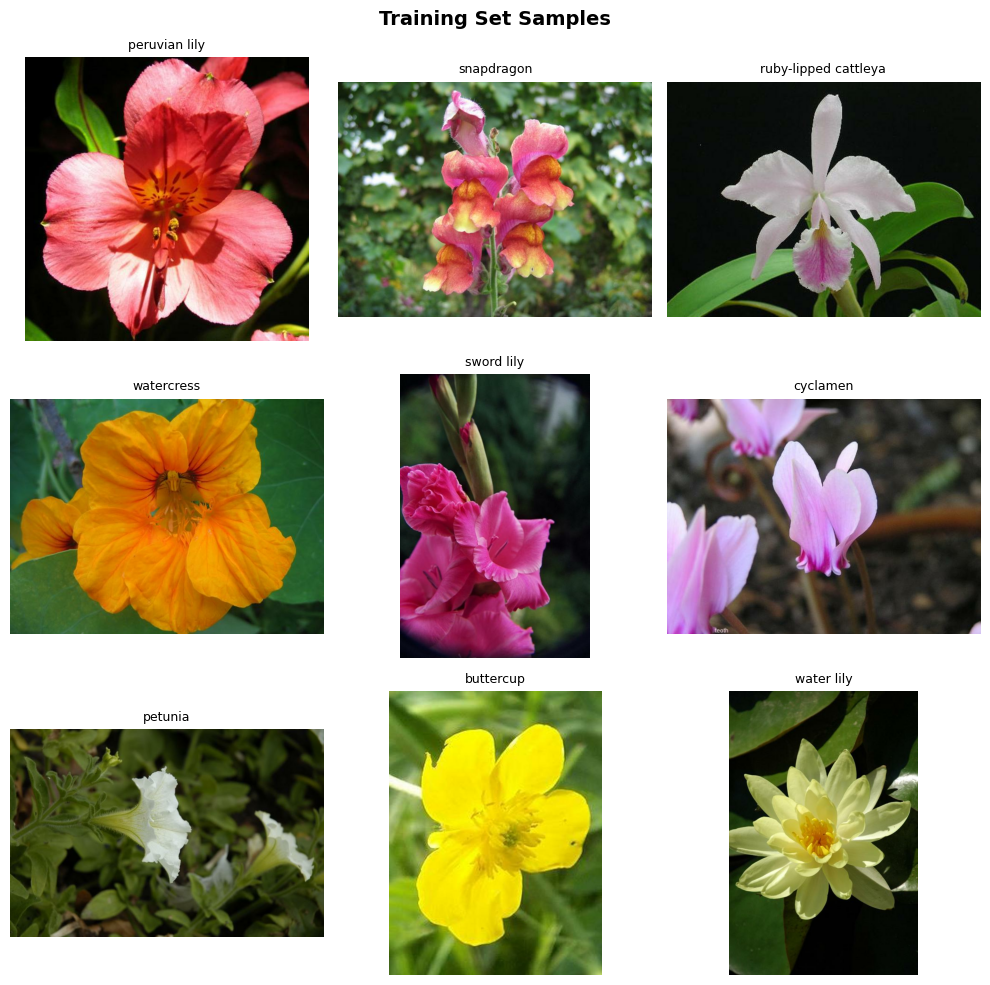

In [13]:
# Display samples from training set
show_samples(X_train, y_train, class_names, "Training Set Samples", n=9)

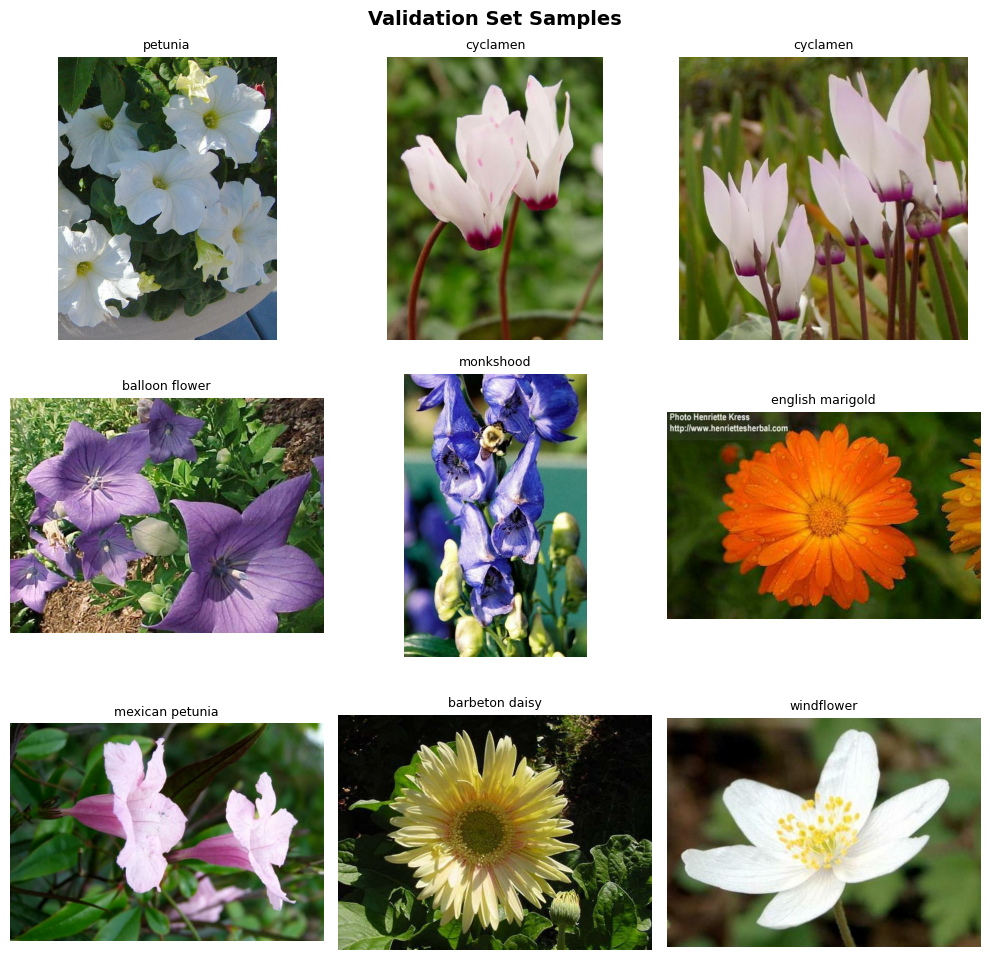

In [14]:
# Display samples from validation set
np.random.seed(RANDOM_SEED + 1)  # Different seed for different samples
show_samples(X_val, y_val, class_names, "Validation Set Samples", n=9)

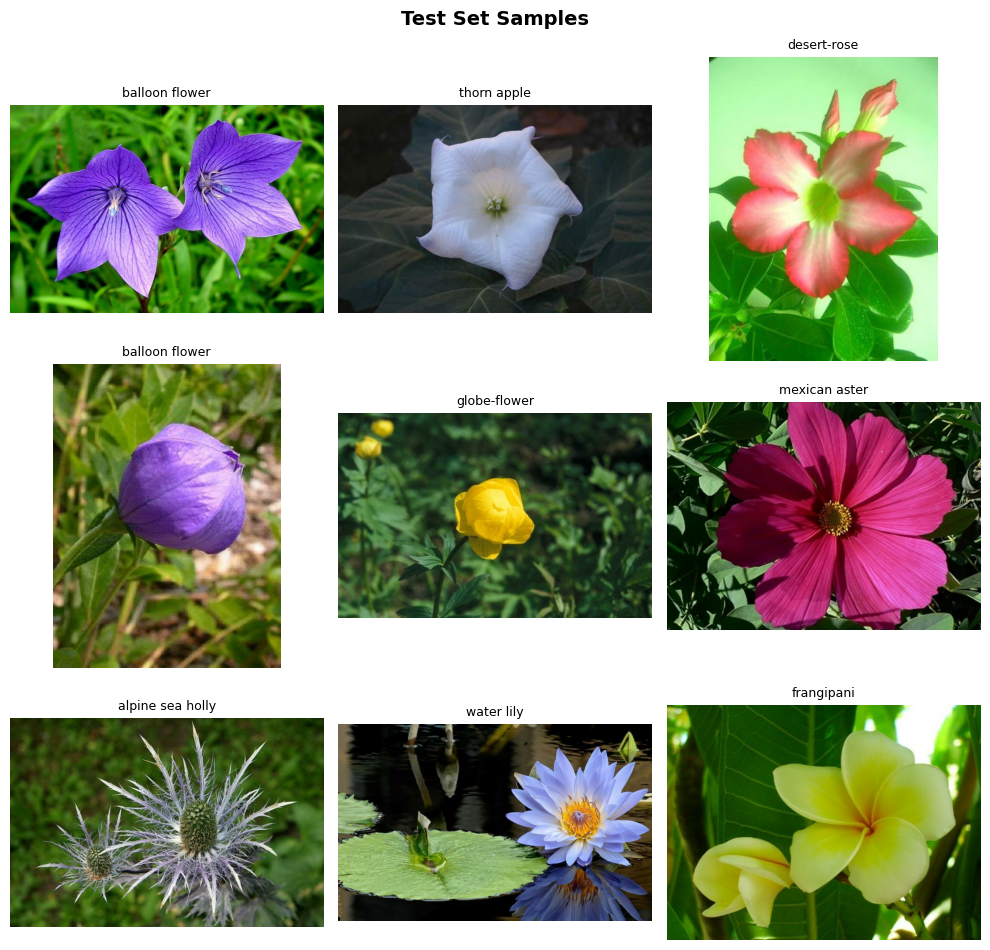

In [15]:
# Display samples from test set
np.random.seed(RANDOM_SEED + 2)  # Different seed for different samples
show_samples(X_test, y_test, class_names, "Test Set Samples", n=9)

## Class Distribution Analysis

The Oxford Flowers 102 dataset has class imbalance, with some flower species having more images than others. We visualize this to understand the imbalance ratio and plan for handling it with class weights during training.

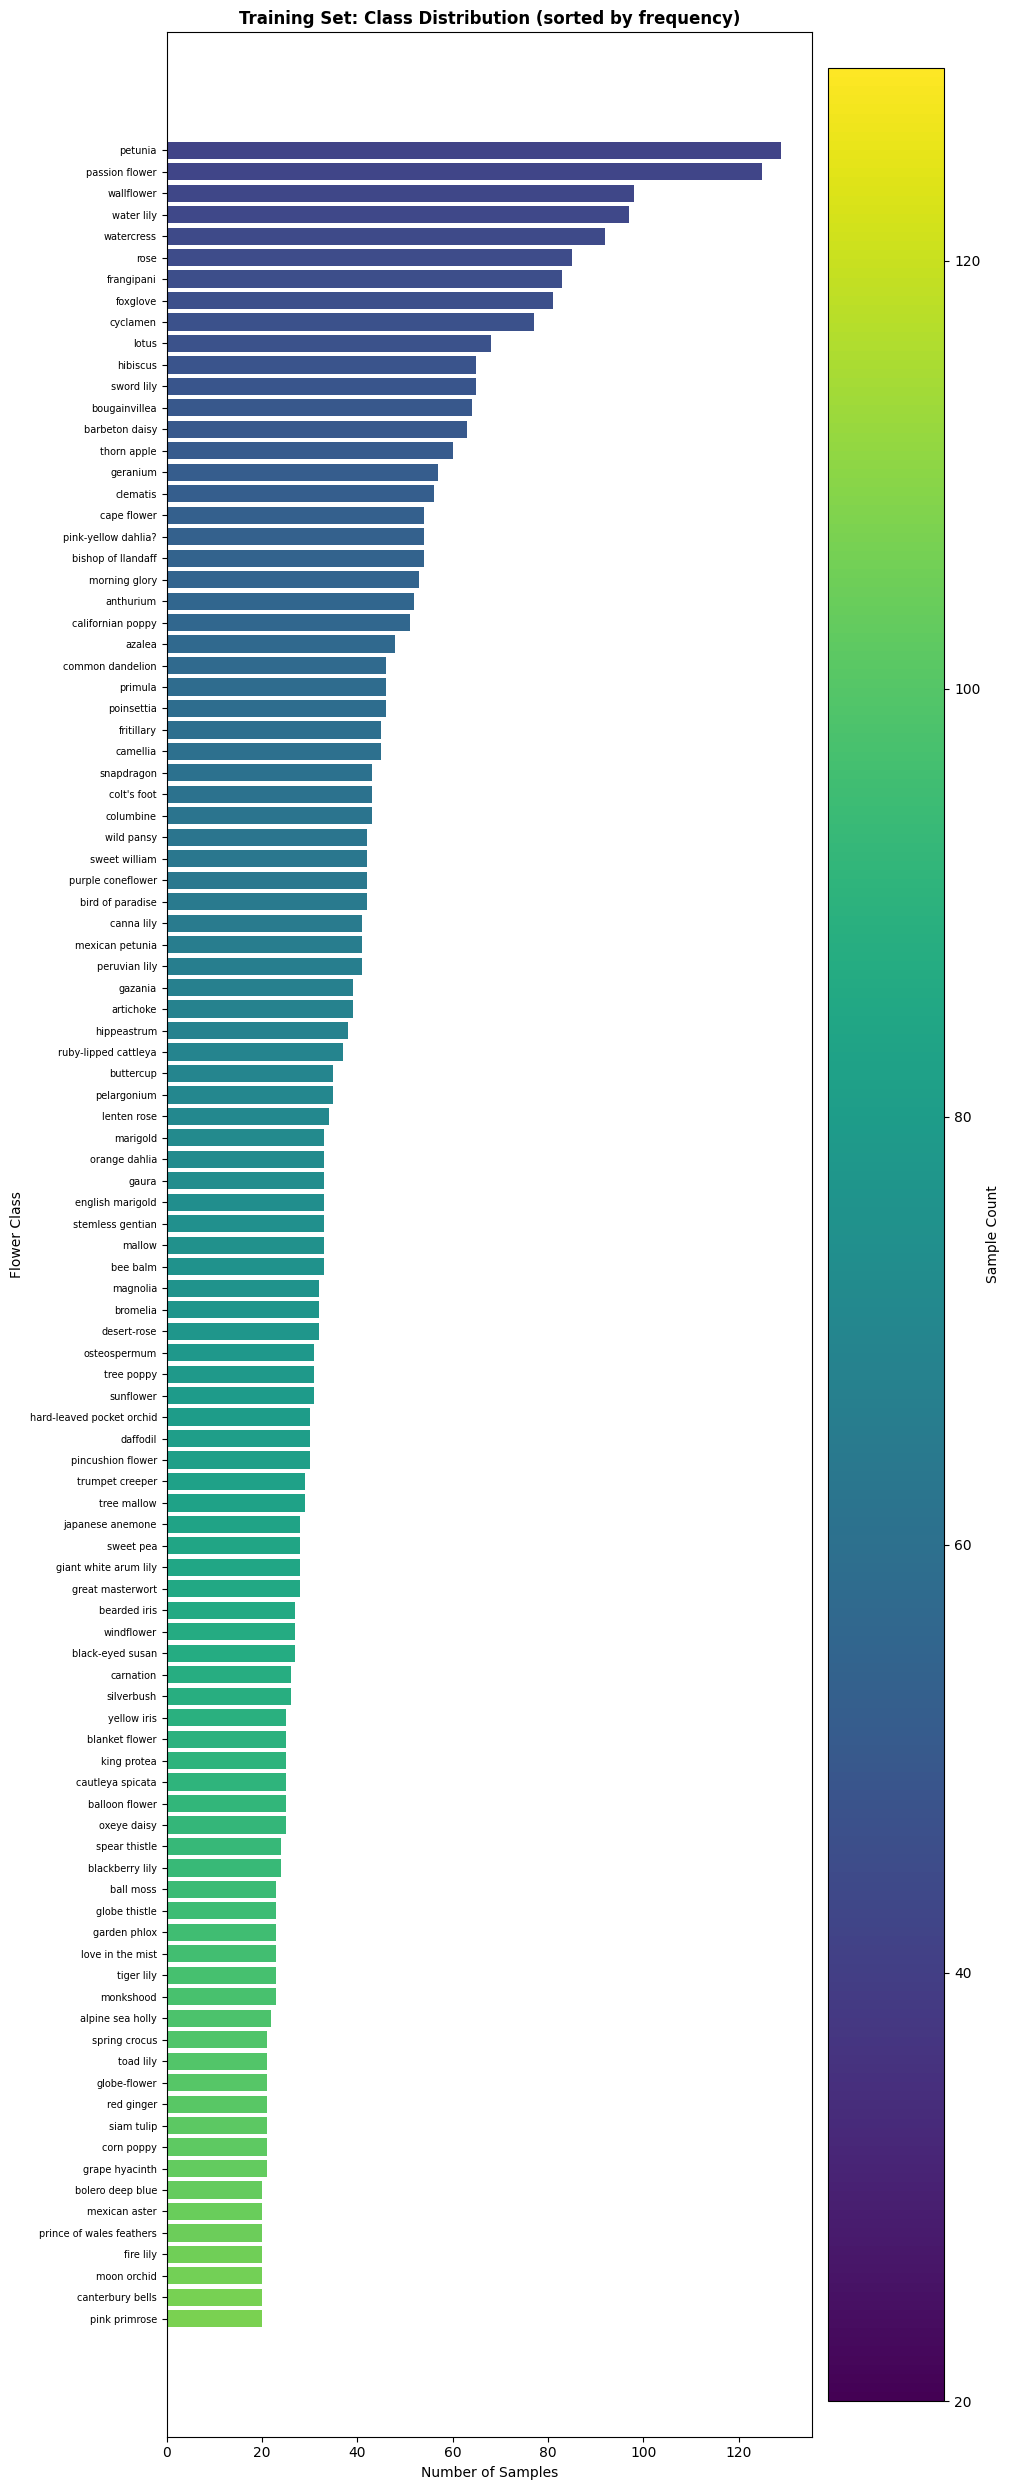

In [16]:
# Create horizontal bar chart of class distribution
unique_classes, counts = np.unique(y_train, return_counts=True)

# Sort by frequency (most to least common)
sorted_indices = np.argsort(counts)[::-1]
sorted_classes = unique_classes[sorted_indices]
sorted_counts = counts[sorted_indices]
sorted_names = [class_names[c] for c in sorted_classes]

# Create color gradient based on frequency
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(sorted_counts)))

# Plot
plt.figure(figsize=(10, 25))
bars = plt.barh(range(len(sorted_names)), sorted_counts, color=colors)
plt.yticks(range(len(sorted_names)), sorted_names, fontsize=7)
plt.xlabel('Number of Samples')
plt.ylabel('Flower Class')
plt.title('Training Set: Class Distribution (sorted by frequency)', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()  # Most common at top

# Add colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=sorted_counts.min(), vmax=sorted_counts.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), pad=0.02)
cbar.set_label('Sample Count')

plt.tight_layout()
plt.show()

In [17]:
# Calculate and display imbalance ratio
imbalance_ratio = counts.max() / counts.min()

print("Class Imbalance Analysis:")
print(f"  Imbalance ratio (max/min): {imbalance_ratio:.2f}x")
print(f"\nTop 5 Most Common Classes:")
for i in range(5):
    print(f"  {sorted_names[i]}: {sorted_counts[i]} samples")

print(f"\nTop 5 Least Common Classes:")
for i in range(-5, 0):
    print(f"  {sorted_names[i]}: {sorted_counts[i]} samples")

print(f"\nTo handle this imbalance, we will use class weights during training.")
print(f"Class weights give higher importance to underrepresented classes.")

Class Imbalance Analysis:
  Imbalance ratio (max/min): 6.45x

Top 5 Most Common Classes:
  petunia: 129 samples
  passion flower: 125 samples
  wallflower: 98 samples
  water lily: 97 samples
  watercress: 92 samples

Top 5 Least Common Classes:
  prince of wales feathers: 20 samples
  fire lily: 20 samples
  moon orchid: 20 samples
  canterbury bells: 20 samples
  pink primrose: 20 samples

To handle this imbalance, we will use class weights during training.
Class weights give higher importance to underrepresented classes.


## Save Splits for Reuse

Save the stratified splits to disk so they can be loaded by the model training notebooks without re-downloading the dataset.

**Note for Google Colab users:** These saved files will be lost when the session ends. To persist them:
1. Mount Google Drive: `from google.colab import drive; drive.mount('/content/drive')`
2. Save to Drive: Use `/content/drive/MyDrive/flower_data/` as the data directory

In [18]:
# Create data directory if it doesn't exist
DATA_DIR = 'data'
os.makedirs(DATA_DIR, exist_ok=True)

# Save splits using np.savez_compressed
# Note: Using allow_pickle=True is required for object arrays (variable-size images)
print("Saving splits to disk...")
np.savez_compressed(
    os.path.join(DATA_DIR, 'flower_splits.npz'),
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test
)
print(f"  Saved: {DATA_DIR}/flower_splits.npz")

# Save class names as pickle
with open(os.path.join(DATA_DIR, 'class_names.pkl'), 'wb') as f:
    pickle.dump(class_names, f)
print(f"  Saved: {DATA_DIR}/class_names.pkl")

# Show file sizes
import os.path
splits_size = os.path.getsize(os.path.join(DATA_DIR, 'flower_splits.npz')) / (1024 * 1024)
names_size = os.path.getsize(os.path.join(DATA_DIR, 'class_names.pkl')) / 1024
print(f"\nFile sizes:")
print(f"  flower_splits.npz: {splits_size:.1f} MB")
print(f"  class_names.pkl: {names_size:.1f} KB")

Saving splits to disk...
  Saved: data/flower_splits.npz
  Saved: data/class_names.pkl

File sizes:
  flower_splits.npz: 5257.2 MB
  class_names.pkl: 1.5 KB


In [19]:
# Demonstrate how to reload the saved splits
print("Demonstrating reload from saved files...")

# Load splits
data = np.load(os.path.join(DATA_DIR, 'flower_splits.npz'), allow_pickle=True)

# Load class names
with open(os.path.join(DATA_DIR, 'class_names.pkl'), 'rb') as f:
    loaded_class_names = pickle.load(f)

# Verify shapes match
print("\nReloaded data shapes:")
print(f"  X_train: {len(data['X_train'])} (original: {len(X_train)})")
print(f"  y_train: {data['y_train'].shape} (original: {y_train.shape})")
print(f"  X_val: {len(data['X_val'])} (original: {len(X_val)})")
print(f"  y_val: {data['y_val'].shape} (original: {y_val.shape})")
print(f"  X_test: {len(data['X_test'])} (original: {len(X_test)})")
print(f"  y_test: {data['y_test'].shape} (original: {y_test.shape})")
print(f"  class_names: {len(loaded_class_names)} classes")

# Verify data matches
assert len(data['X_train']) == len(X_train), "Train images mismatch!"
assert np.array_equal(data['y_train'], y_train), "Train labels mismatch!"
assert len(data['X_val']) == len(X_val), "Val images mismatch!"
assert np.array_equal(data['y_val'], y_val), "Val labels mismatch!"
assert len(data['X_test']) == len(X_test), "Test images mismatch!"
assert np.array_equal(data['y_test'], y_test), "Test labels mismatch!"

print("\nAll data verified successfully!")

Demonstrating reload from saved files...

Reloaded data shapes:
  X_train: 4094 (original: 4094)
  y_train: (4094,) (original: (4094,))
  X_val: 2047 (original: 2047)
  y_val: (2047,) (original: (2047,))
  X_test: 2048 (original: 2048)
  y_test: (2048,) (original: (2048,))
  class_names: 102 classes

All data verified successfully!


## Data Augmentation

Data augmentation is critical for flower classification to improve model generalization. We create a flower-specific augmentation pipeline that includes both geometric and color transformations.

**Key considerations for flower classification:**
- **Color is discriminative:** Many flower species are distinguished primarily by color (e.g., yellow iris vs purple iris), so we use moderate color augmentation that adds variation without destroying color identity
- **Orientation matters:** We use only horizontal flips (no vertical) because flowers typically have a natural upward orientation
- **Avoid aggressive hue shifts:** Large hue changes could turn a red flower blue, confusing the model about species identity

In [20]:
def create_flower_augmentation():
    """
    Create an augmentation pipeline optimized for flower classification.

    Includes:
    - Geometric transforms: horizontal flip, rotation, zoom
    - Color transforms: brightness, contrast, saturation (critical for flowers)

    NOTE: We do NOT use vertical flip (flowers have natural orientation)
    NOTE: We do NOT use aggressive hue shifts (would destroy color identity)

    Returns:
        tf.keras.Sequential: Augmentation layer that can be applied to image batches
    """
    return tf.keras.Sequential([
        # Geometric transformations
        tf.keras.layers.RandomFlip("horizontal"),  # Only horizontal - flowers have natural up orientation
        tf.keras.layers.RandomRotation(0.15),      # +/- 27 degrees (0.15 * 180)
        tf.keras.layers.RandomZoom((-0.1, 0.1)),   # +/- 10% zoom

        # Color augmentations (critical for flower classification!)
        # These help the model be robust to lighting conditions while preserving color identity
        tf.keras.layers.RandomBrightness(factor=0.2),   # +/- 20% brightness
        tf.keras.layers.RandomContrast(factor=0.2),     # +/- 20% contrast
        # Note: For RandomSaturation, 0.5 is no-op (not 1.0!)
        # Range (0.4, 0.6) gives subtle saturation variation
        # Avoiding large changes preserves the discriminative color information
    ], name='flower_augmentation')

# Create the augmentation layer
augmentation_layer = create_flower_augmentation()
print("Flower augmentation layer created:")
print(augmentation_layer.summary())

Flower augmentation layer created:


Model: "flower_augmentation"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ ?                      │   0 (unbuilt) │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness               │ ?                      │   0 (unbuilt) │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ ?                      │   0 (unbuilt) │
│ (RandomContrast)                │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [21]:
# Verify augmentation layer works on a sample batch
# First, resize a few images to consistent size for testing
sample_images = []
for i in range(4):
    img = tf.image.resize(X_train[i], IMG_SIZE)
    sample_images.append(img)

sample_batch = tf.stack(sample_images)
print(f"Sample batch shape: {sample_batch.shape}")

# Apply augmentation (with training=True to enable random transforms)
augmented_batch = augmentation_layer(sample_batch, training=True)
print(f"Augmented batch shape: {augmented_batch.shape}")
print("Augmentation layer verified working!")

Sample batch shape: (4, 224, 224, 3)
Augmented batch shape: (4, 224, 224, 3)
Augmentation layer verified working!


In [22]:
def plot_augmentation_comparison(original_image, augmentation_layer, n_variations=8, figsize=(15, 6)):
    """
    Show original image alongside augmented versions.

    Args:
        original_image: Input image (numpy array or tensor)
        augmentation_layer: Keras augmentation layer to apply
        n_variations: Number of augmented versions to show (default 8)
        figsize: Figure size tuple
    """
    # Ensure image is tensor and has correct shape for augmentation
    if isinstance(original_image, np.ndarray):
        image_tensor = tf.constant(original_image, dtype=tf.float32)
    else:
        image_tensor = tf.cast(original_image, tf.float32)

    # Resize to standard size if needed
    if image_tensor.shape[0] != IMG_SIZE[0] or image_tensor.shape[1] != IMG_SIZE[1]:
        image_tensor = tf.image.resize(image_tensor, IMG_SIZE)

    # Calculate grid layout: original + n_variations
    total_images = n_variations + 1
    n_cols = min(5, total_images)
    n_rows = (total_images + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten() if n_rows > 1 or n_cols > 1 else [axes]

    # Show original
    display_img = image_tensor.numpy()
    if display_img.max() > 1:
        display_img = display_img.astype(np.uint8)
    axes[0].imshow(display_img)
    axes[0].set_title('Original', fontweight='bold', fontsize=10)
    axes[0].axis('off')

    # Generate and show augmented versions
    for i in range(n_variations):
        # Apply augmentation (add batch dimension, then remove)
        augmented = augmentation_layer(tf.expand_dims(image_tensor, 0), training=True)
        aug_img = augmented[0].numpy()

        # Clip values to valid range and convert to displayable format
        aug_img = np.clip(aug_img, 0, 255)
        if aug_img.max() > 1:
            aug_img = aug_img.astype(np.uint8)

        axes[i + 1].imshow(aug_img)
        axes[i + 1].set_title(f'Augmented {i+1}', fontsize=9)
        axes[i + 1].axis('off')

    # Hide any unused axes
    for i in range(total_images, len(axes)):
        axes[i].axis('off')

    plt.suptitle('Data Augmentation Variations', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

Visualizing augmentation effects on 3 different flower images:

Image 1: tree mallow


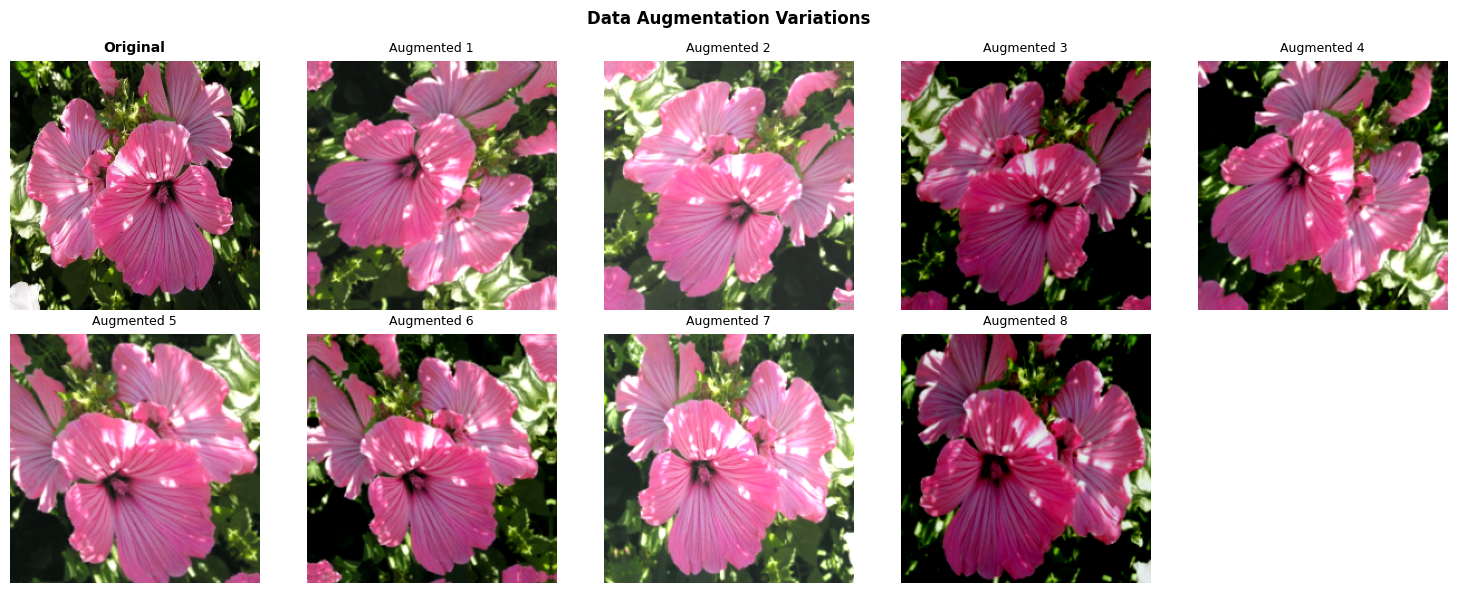

In [23]:
# Visualize augmentation effects on 3 different flower images
# Select images from different classes for diversity
print("Visualizing augmentation effects on 3 different flower images:\n")

# Image 1: First random sample
idx1 = 0
print(f"Image 1: {class_names[y_train[idx1]]}")
plot_augmentation_comparison(X_train[idx1], augmentation_layer, n_variations=8)

Image 2: cyclamen


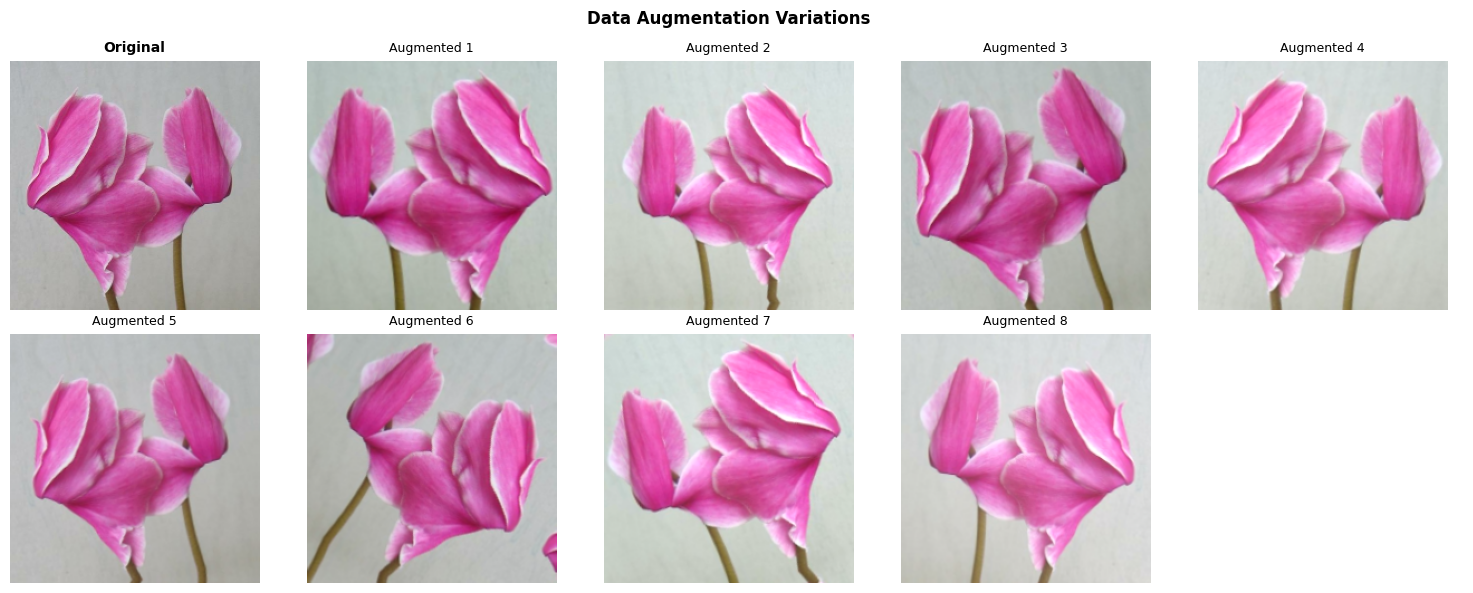

In [24]:
# Image 2: A different flower class (mid-range index)
idx2 = 500
print(f"Image 2: {class_names[y_train[idx2]]}")
plot_augmentation_comparison(X_train[idx2], augmentation_layer, n_variations=8)

Image 3: purple coneflower


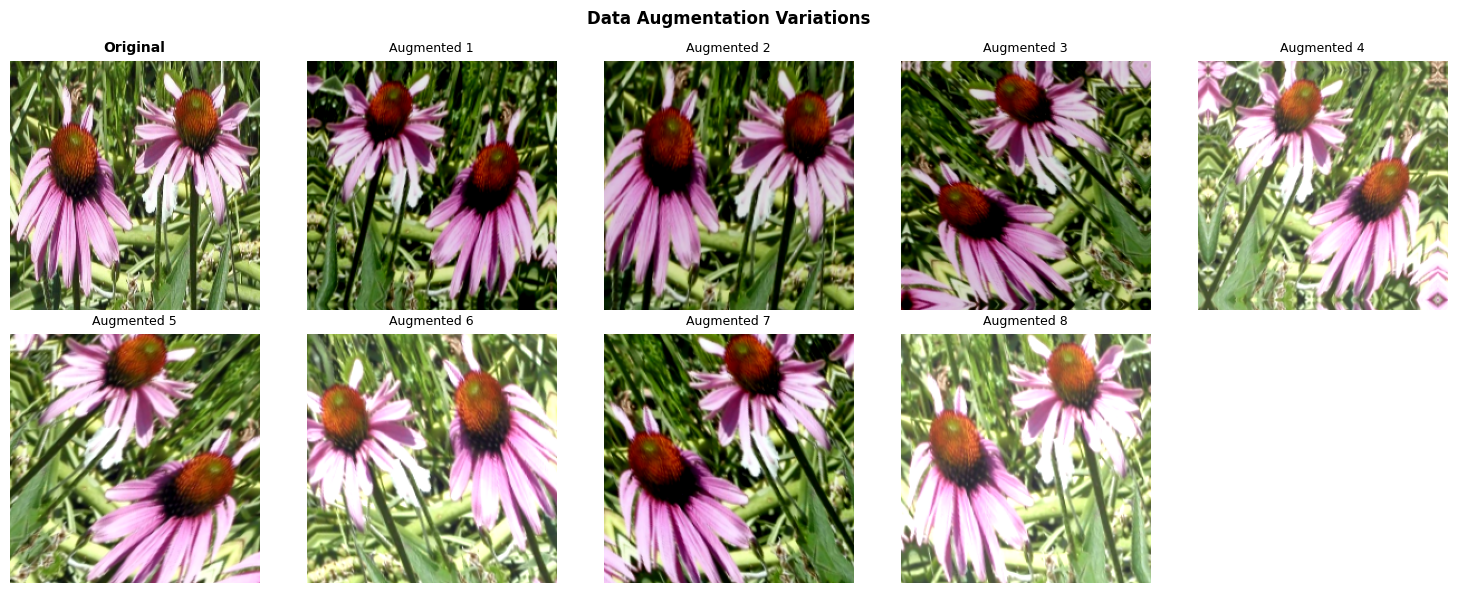

In [25]:
# Image 3: Another different flower class (later index)
idx3 = 1500
print(f"Image 3: {class_names[y_train[idx3]]}")
plot_augmentation_comparison(X_train[idx3], augmentation_layer, n_variations=8)

### Augmentation Parameter Choices

Our augmentation parameters are optimized for flower classification:

| Transform | Value | Rationale |
|-----------|-------|-----------|
| **RandomFlip** | horizontal only | Flowers have natural upward orientation; vertical flip unnatural |
| **RandomRotation** | 0.15 (±27 deg) | Moderate rotation for camera angle variation without extreme tilts |
| **RandomZoom** | ±10% | Simulates different camera distances |
| **RandomBrightness** | ±20% | Handles outdoor lighting variation |
| **RandomContrast** | ±20% | Handles different lighting conditions |

**Why no hue augmentation?** Color is a primary discriminative feature for flowers (e.g., yellow iris vs purple iris). Shifting hue could transform one flower species into another, confusing the model during training.

**Why moderate color augmentation?** We want the model to be robust to lighting conditions (brightness, contrast) while preserving the actual colors that distinguish flower species.

## tf.data Pipeline

We create efficient data pipelines using `tf.data` API for high-performance training. Key optimizations:
- **`from_generator`**: Handles variable-size images from our numpy arrays
- **`AUTOTUNE`**: Automatically tunes parallelism for optimal performance
- **`prefetch`**: Overlaps data preprocessing with model execution
- **`cache`**: Caches preprocessed data in memory (for eval datasets only)

The training pipeline includes augmentation; validation/test pipelines do not.

In [26]:
# tf.data pipeline configuration
AUTOTUNE = tf.data.AUTOTUNE

def preprocess_image(image, label):
    """
    Preprocess a single image: resize and cast to float32.

    Args:
        image: Input image tensor (variable size)
        label: Class label

    Returns:
        Tuple of (resized_image, label)
    """
    # Resize to standard size
    image = tf.image.resize(image, IMG_SIZE)
    # Cast to float32 for model input
    image = tf.cast(image, tf.float32)
    return image, label

print(f"AUTOTUNE value: {AUTOTUNE}")
print("preprocess_image function defined")

AUTOTUNE value: -1
preprocess_image function defined


In [27]:
def create_train_dataset(images, labels, augmentation_layer, batch_size=BATCH_SIZE):
    """
    Create a training dataset with augmentation.

    Pipeline: from_generator -> preprocess -> shuffle -> batch -> augment -> prefetch

    Args:
        images: Numpy array of images (variable sizes, dtype=object)
        labels: Numpy array of labels
        augmentation_layer: Keras augmentation layer to apply
        batch_size: Batch size for training

    Returns:
        tf.data.Dataset ready for training
    """
    # Create generator function for variable-size images
    def generator():
        for img, lbl in zip(images, labels):
            yield img, lbl

    # Define output signature for the generator
    output_signature = (
        tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
        tf.TensorSpec(shape=(), dtype=tf.int64)
    )

    # Create dataset from generator
    ds = tf.data.Dataset.from_generator(
        generator,
        output_signature=output_signature
    )

    # Apply preprocessing (resize, cast to float32)
    ds = ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)

    # Shuffle for training
    ds = ds.shuffle(buffer_size=1000)

    # Batch the data
    ds = ds.batch(batch_size)

    # Apply augmentation to batches (training=True enables random transforms)
    ds = ds.map(
        lambda x, y: (augmentation_layer(x, training=True), y),
        num_parallel_calls=AUTOTUNE
    )

    # Prefetch for performance
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

print("create_train_dataset function defined")

create_train_dataset function defined


In [28]:
def create_eval_dataset(images, labels, batch_size=BATCH_SIZE):
    """
    Create an evaluation dataset (validation or test) without augmentation.

    Pipeline: from_generator -> preprocess -> batch -> cache -> prefetch

    Args:
        images: Numpy array of images (variable sizes, dtype=object)
        labels: Numpy array of labels
        batch_size: Batch size for evaluation

    Returns:
        tf.data.Dataset ready for evaluation
    """
    # Create generator function for variable-size images
    def generator():
        for img, lbl in zip(images, labels):
            yield img, lbl

    # Define output signature for the generator
    output_signature = (
        tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
        tf.TensorSpec(shape=(), dtype=tf.int64)
    )

    # Create dataset from generator
    ds = tf.data.Dataset.from_generator(
        generator,
        output_signature=output_signature
    )

    # Apply preprocessing (resize, cast to float32)
    ds = ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)

    # NO shuffle for evaluation (deterministic results)
    # NO augmentation for evaluation

    # Batch the data
    ds = ds.batch(batch_size)

    # Cache after batching for memory efficiency
    ds = ds.cache()

    # Prefetch for performance
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

print("create_eval_dataset function defined")

create_eval_dataset function defined


In [29]:
# Create datasets using our pipeline functions
print("Creating tf.data pipelines...")

train_ds = create_train_dataset(X_train, y_train, augmentation_layer)
val_ds = create_eval_dataset(X_val, y_val)
test_ds = create_eval_dataset(X_test, y_test)

print(f"\nDatasets created:")
print(f"  train_ds: {train_ds}")
print(f"  val_ds: {val_ds}")
print(f"  test_ds: {test_ds}")

# Verify we can iterate over a batch
for images, labels in train_ds.take(1):
    print(f"\nSample batch from train_ds:")
    print(f"  Images shape: {images.shape}")
    print(f"  Labels shape: {labels.shape}")
    print(f"  Image dtype: {images.dtype}")
    print(f"  Image value range: [{images.numpy().min():.1f}, {images.numpy().max():.1f}]")

print("\ntf.data pipelines verified working!")

Creating tf.data pipelines...

Datasets created:
  train_ds: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
  val_ds: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
  test_ds: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

Sample batch from train_ds:
  Images shape: (32, 224, 224, 3)
  Labels shape: (32,)
  Image dtype: <dtype: 'float32'>
  Image value range: [0.0, 255.0]

tf.data pipelines verified working!


## Model-Specific Preprocessing

Different pretrained models require different input preprocessing. Using the wrong preprocessing for a model can significantly hurt transfer learning performance.

| Model | Input Range | Preprocessing | Notes |
|-------|-------------|---------------|-------|
| **VGG16/VGG19** | BGR, zero-centered | `vgg19.preprocess_input` | Converts RGB to BGR, subtracts ImageNet mean |
| **ResNet50** | BGR, zero-centered | `resnet50.preprocess_input` | Same as VGG |
| **EfficientNet** | [0, 255] float | None (pass-through) | Has built-in Rescaling layer |

**CRITICAL:** EfficientNet does NOT need `Rescaling(1./255)` - it expects raw [0, 255] pixel values and handles normalization internally.

In [30]:
def get_preprocessing_fn(model_name):
    """
    Return the appropriate preprocessing function for each model.

    Args:
        model_name: String, one of 'vgg19', 'vgg16', 'resnet50', 'efficientnet'

    Returns:
        Preprocessing function that transforms images to model-expected format

    Usage:
        preprocess_fn = get_preprocessing_fn('vgg19')
        preprocessed_batch = preprocess_fn(image_batch)
    """
    model_name = model_name.lower()

    if model_name in ['vgg16', 'vgg19']:
        # VGG expects BGR format with zero-centered pixels
        from tensorflow.keras.applications.vgg19 import preprocess_input
        return preprocess_input

    elif model_name == 'resnet50':
        # ResNet50 also uses BGR, zero-centered format
        from tensorflow.keras.applications.resnet50 import preprocess_input
        return preprocess_input

    elif model_name.startswith('efficientnet'):
        # EfficientNet expects [0, 255] float - has built-in normalization
        # Just ensure float32, no scaling needed
        return lambda x: tf.cast(x, tf.float32)

    else:
        # Default: scale to [0, 1]
        print(f"Warning: Unknown model '{model_name}', using default [0,1] scaling")
        return lambda x: tf.cast(x, tf.float32) / 255.0

print("get_preprocessing_fn function defined")
print("\nSupported models: vgg16, vgg19, resnet50, efficientnet*")

get_preprocessing_fn function defined

Supported models: vgg16, vgg19, resnet50, efficientnet*


In [31]:
# Demonstrate preprocessing differences between models
print("Comparing preprocessing outputs for different models:\n")

# Get a sample image batch
sample_img = tf.image.resize(X_train[0], IMG_SIZE)
sample_batch = tf.expand_dims(sample_img, 0)  # Add batch dimension
sample_batch = tf.cast(sample_batch, tf.float32)

print(f"Original image batch:")
print(f"  Shape: {sample_batch.shape}")
print(f"  Range: [{sample_batch.numpy().min():.1f}, {sample_batch.numpy().max():.1f}]")

# Test each preprocessing function
for model_name in ['vgg19', 'resnet50', 'efficientnetb0']:
    preprocess_fn = get_preprocessing_fn(model_name)
    preprocessed = preprocess_fn(sample_batch.numpy().copy())

    # Convert to numpy if it's a tensor (EfficientNet returns tensor)
    if hasattr(preprocessed, 'numpy'):
        preprocessed = preprocessed.numpy()

    print(f"\n{model_name.upper()} preprocessed:")
    print(f"  Range: [{preprocessed.min():.1f}, {preprocessed.max():.1f}]")

Comparing preprocessing outputs for different models:

Original image batch:
  Shape: (1, 224, 224, 3)
  Range: [0.0, 255.0]

VGG19 preprocessed:
  Range: [-123.7, 151.1]

RESNET50 preprocessed:
  Range: [-123.7, 151.1]

EFFICIENTNETB0 preprocessed:
  Range: [0.0, 255.0]


## Class Weights for Imbalanced Data

To handle class imbalance, we compute class weights using sklearn's `compute_class_weight` with `class_weight='balanced'`. This gives higher weight to underrepresented classes, making the model pay more attention to rare flower species.

**Formula:** `weight[class] = n_samples / (n_classes * n_samples_class)`

This means:
- A class with fewer samples gets a **higher** weight
- A class with more samples gets a **lower** weight
- The weights are normalized so the average is approximately 1.0

In [32]:
def compute_class_weights(labels, num_classes=102):
    """
    Compute balanced class weights for handling class imbalance.

    Args:
        labels: Array of class labels from training set
        num_classes: Total number of classes (default 102)

    Returns:
        dict: Mapping from class index to weight value

    Usage:
        class_weights = compute_class_weights(y_train)
        model.fit(train_ds, class_weight=class_weights, ...)
    """
    # Compute balanced weights using sklearn
    weights = compute_class_weight(
        class_weight='balanced',
        classes=np.arange(num_classes),
        y=labels
    )

    # Convert to dictionary format required by Keras
    class_weights = {i: w for i, w in enumerate(weights)}

    return class_weights

# Compute class weights from training labels
class_weights = compute_class_weights(y_train)

print("Class weights computed!")
print(f"  Number of weights: {len(class_weights)}")
print(f"  Weight range: [{min(class_weights.values()):.3f}, {max(class_weights.values()):.3f}]")
print(f"  Mean weight: {np.mean(list(class_weights.values())):.3f}")

Class weights computed!
  Number of weights: 102
  Weight range: [0.311, 2.007]
  Mean weight: 1.225


In [33]:
# Display class weights for most and least common classes
# Get class indices sorted by weight (highest weight = rarest class)
sorted_by_weight = sorted(class_weights.items(), key=lambda x: x[1], reverse=True)

print("Classes with HIGHEST weights (rarest, need most attention):")
for class_idx, weight in sorted_by_weight[:5]:
    print(f"  {class_names[class_idx]}: weight={weight:.3f}")

print("\nClasses with LOWEST weights (most common, already well-represented):")
for class_idx, weight in sorted_by_weight[-5:]:
    print(f"  {class_names[class_idx]}: weight={weight:.3f}")

print("\nUsage in model.fit():")
print("  model.fit(train_ds, validation_data=val_ds, class_weight=class_weights, ...)")

Classes with HIGHEST weights (rarest, need most attention):
  pink primrose: weight=2.007
  canterbury bells: weight=2.007
  moon orchid: weight=2.007
  fire lily: weight=2.007
  prince of wales feathers: weight=2.007

Classes with LOWEST weights (most common, already well-represented):
  watercress: weight=0.436
  water lily: weight=0.414
  wallflower: weight=0.410
  passion flower: weight=0.321
  petunia: weight=0.311

Usage in model.fit():
  model.fit(train_ds, validation_data=val_ds, class_weight=class_weights, ...)


## Pipeline Performance Benchmark

We benchmark the data pipeline to measure throughput (images per second). This helps verify the pipeline is fast enough to keep the GPU busy during training. A good pipeline should achieve throughput significantly higher than model training speed.

In [34]:
import time

def benchmark_pipeline(dataset, num_batches=50, warmup_batches=5):
    """
    Benchmark data pipeline throughput.

    Args:
        dataset: tf.data.Dataset to benchmark
        num_batches: Number of batches to iterate over for timing
        warmup_batches: Number of batches to skip (warm up the pipeline)

    Returns:
        dict with timing results
    """
    # Warmup: iterate through a few batches to initialize the pipeline
    print(f"Warming up ({warmup_batches} batches)...")
    for i, (images, labels) in enumerate(dataset.take(warmup_batches)):
        pass

    # Benchmark
    print(f"Benchmarking ({num_batches} batches)...")
    batch_times = []
    total_images = 0

    start_time = time.time()
    for i, (images, labels) in enumerate(dataset.take(num_batches)):
        batch_start = time.time()
        # Force execution by accessing the data
        _ = images.shape[0]
        total_images += images.shape[0]
        batch_times.append(time.time() - batch_start)

    total_time = time.time() - start_time

    # Calculate statistics
    results = {
        'total_time': total_time,
        'total_images': total_images,
        'images_per_second': total_images / total_time,
        'avg_batch_time': np.mean(batch_times),
        'batches_per_second': num_batches / total_time
    }

    return results

print("benchmark_pipeline function defined")

benchmark_pipeline function defined


In [35]:
# Benchmark the training pipeline (includes augmentation)
print("=" * 50)
print("TRAINING PIPELINE BENCHMARK")
print("=" * 50)

# Recreate the train dataset for fresh benchmark
train_ds_bench = create_train_dataset(X_train, y_train, augmentation_layer)
train_results = benchmark_pipeline(train_ds_bench, num_batches=50)

print(f"\nResults:")
print(f"  Total time: {train_results['total_time']:.2f} seconds")
print(f"  Total images: {train_results['total_images']}")
print(f"  Throughput: {train_results['images_per_second']:.1f} images/second")
print(f"  Avg batch time: {train_results['avg_batch_time']*1000:.1f} ms")
print(f"  Batches/second: {train_results['batches_per_second']:.1f}")

print("\n" + "=" * 50)
print("VALIDATION PIPELINE BENCHMARK")
print("=" * 50)

# Recreate the val dataset for fresh benchmark
val_ds_bench = create_eval_dataset(X_val, y_val)
val_results = benchmark_pipeline(val_ds_bench, num_batches=30)

print(f"\nResults:")
print(f"  Total time: {val_results['total_time']:.2f} seconds")
print(f"  Total images: {val_results['total_images']}")
print(f"  Throughput: {val_results['images_per_second']:.1f} images/second")
print(f"  Avg batch time: {val_results['avg_batch_time']*1000:.1f} ms")
print(f"  Batches/second: {val_results['batches_per_second']:.1f}")

# Summary
print("\n" + "=" * 50)
print("SUMMARY")
print("=" * 50)
print(f"Training pipeline: {train_results['images_per_second']:.0f} img/s (with augmentation)")
print(f"Validation pipeline: {val_results['images_per_second']:.0f} img/s (no augmentation)")
print("\nNote: These numbers will vary based on hardware (CPU/GPU) and system load.")

TRAINING PIPELINE BENCHMARK
Warming up (5 batches)...
Benchmarking (50 batches)...

Results:
  Total time: 3.95 seconds
  Total images: 1600
  Throughput: 404.6 images/second
  Avg batch time: 0.0 ms
  Batches/second: 12.6

VALIDATION PIPELINE BENCHMARK
Warming up (5 batches)...
Benchmarking (30 batches)...

Results:
  Total time: 0.84 seconds
  Total images: 960
  Throughput: 1139.8 images/second
  Avg batch time: 0.0 ms
  Batches/second: 35.6

SUMMARY
Training pipeline: 405 img/s (with augmentation)
Validation pipeline: 1140 img/s (no augmentation)

Note: These numbers will vary based on hardware (CPU/GPU) and system load.


## Reusable Data Loading Cell for Model Notebooks

The following cell is designed to be copied into model training notebooks. It loads pre-saved data splits, creates the augmentation layer, builds tf.data pipelines, and computes class weights - everything needed to start training.

**Usage:** Copy the cell below to the beginning of any model training notebook.

In [36]:
# =============================================================================
# REUSABLE DATA LOADING CELL - Copy this to model training notebooks
# =============================================================================
# This cell loads pre-saved data splits, creates tf.data pipelines with
# augmentation, and computes class weights. Run this at the start of any
# model training notebook.
#
# Prerequisites: Run 01_data_pipeline.ipynb first to create saved splits.
# =============================================================================

import tensorflow as tf
import numpy as np
import pickle
import os
from sklearn.utils.class_weight import compute_class_weight

# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
RANDOM_SEED = 42
DATA_DIR = 'data'  # Change to your data directory
NUM_CLASSES = 102
AUTOTUNE = tf.data.AUTOTUNE

# Set random seeds for reproducibility
import keras
keras.utils.set_random_seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

# --- 1. Load pre-saved data splits ---
print("Loading data splits...")
data = np.load(os.path.join(DATA_DIR, 'flower_splits.npz'), allow_pickle=True)
X_train, y_train = data['X_train'], data['y_train']
X_val, y_val = data['X_val'], data['y_val']
X_test, y_test = data['X_test'], data['y_test']

with open(os.path.join(DATA_DIR, 'class_names.pkl'), 'rb') as f:
    class_names = pickle.load(f)

print(f"  Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

# --- 2. Create augmentation layer ---
augmentation_layer = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomZoom((-0.1, 0.1)),
    tf.keras.layers.RandomBrightness(factor=0.2),
    tf.keras.layers.RandomContrast(factor=0.2),
], name='flower_augmentation')

# --- 3. Define pipeline functions ---
def preprocess_image(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32)
    return image, label

def create_train_dataset(images, labels, augmentation_layer, batch_size=BATCH_SIZE):
    def generator():
        for img, lbl in zip(images, labels):
            yield img, lbl
    output_signature = (
        tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
        tf.TensorSpec(shape=(), dtype=tf.int64)
    )
    ds = tf.data.Dataset.from_generator(generator, output_signature=output_signature)
    ds = ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.map(lambda x, y: (augmentation_layer(x, training=True), y), num_parallel_calls=AUTOTUNE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

def create_eval_dataset(images, labels, batch_size=BATCH_SIZE):
    def generator():
        for img, lbl in zip(images, labels):
            yield img, lbl
    output_signature = (
        tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
        tf.TensorSpec(shape=(), dtype=tf.int64)
    )
    ds = tf.data.Dataset.from_generator(generator, output_signature=output_signature)
    ds = ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.cache()
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

# --- 4. Create tf.data pipelines ---
print("Creating tf.data pipelines...")
train_ds = create_train_dataset(X_train, y_train, augmentation_layer)
val_ds = create_eval_dataset(X_val, y_val)
test_ds = create_eval_dataset(X_test, y_test)

# --- 5. Compute class weights ---
weights = compute_class_weight('balanced', classes=np.arange(NUM_CLASSES), y=y_train)
class_weights = {i: w for i, w in enumerate(weights)}

print(f"  Class weights range: [{min(class_weights.values()):.2f}, {max(class_weights.values()):.2f}]")
print("\nData loading complete! Available variables:")
print("  - train_ds, val_ds, test_ds (tf.data.Dataset)")
print("  - X_train, y_train, X_val, y_val, X_test, y_test (numpy arrays)")
print("  - class_names (list), class_weights (dict)")
print("  - augmentation_layer (Keras layer)")
print("  - IMG_SIZE, BATCH_SIZE, NUM_CLASSES (config)")
# =============================================================================

Loading data splits...
  Train: 4094 | Val: 2047 | Test: 2048
Creating tf.data pipelines...
  Class weights range: [0.31, 2.01]

Data loading complete! Available variables:
  - train_ds, val_ds, test_ds (tf.data.Dataset)
  - X_train, y_train, X_val, y_val, X_test, y_test (numpy arrays)
  - class_names (list), class_weights (dict)
  - augmentation_layer (Keras layer)
  - IMG_SIZE, BATCH_SIZE, NUM_CLASSES (config)
